## **Loading Libraries & Other Necessary Functions**

In [ ]:
# Import OS libraries
import os
import itertools

# Data handling tools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import cv2
import os
import imutils
import tensorflow as tf
import keras


In [ ]:
from google.colab import files
from io import BytesIO
# Display images.
from IPython.display import display
from PIL import ImageEnhance
from PIL import Image

In [ ]:
!pip install Pillow

In [ ]:

from glob import glob
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

**Inception Related Info**

In [ ]:
inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
for layer in inception.layers:
   layer.trainable=False

In [ ]:
import os
import shutil

In [ ]:
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalizati

In [ ]:
for layer in inception.layers:
    print(layer.name, layer.trainable)

input_1 False
conv2d False
batch_normalization False
activation False
conv2d_1 False
batch_normalization_1 False
activation_1 False
conv2d_2 False
batch_normalization_2 False
activation_2 False
max_pooling2d False
conv2d_3 False
batch_normalization_3 False
activation_3 False
conv2d_4 False
batch_normalization_4 False
activation_4 False
max_pooling2d_1 False
conv2d_8 False
batch_normalization_8 False
activation_8 False
conv2d_6 False
conv2d_9 False
batch_normalization_6 False
batch_normalization_9 False
activation_6 False
activation_9 False
average_pooling2d False
conv2d_5 False
conv2d_7 False
conv2d_10 False
conv2d_11 False
batch_normalization_5 False
batch_normalization_7 False
batch_normalization_10 False
batch_normalization_11 False
activation_5 False
activation_7 False
activation_10 False
activation_11 False
mixed0 False
conv2d_15 False
batch_normalization_15 False
activation_15 False
conv2d_13 False
conv2d_16 False
batch_normalization_13 False
batch_normalization_16 False
activati

**Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Loading Training & Testing Sets**

In [ ]:
test_set = '/content/drive/MyDrive/MRI data Ashif_zahin/Testing'
train_set='/content/drive/MyDrive/MRI data Ashif_zahin/Training'

In [ ]:
test_set = '/content/drive/MyDrive/Dataset/Testing'
train_set='/content/drive/MyDrive/Dataset/Training'

In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
test=data('/content/drive/MyDrive/Dataset/Testing')

In [ ]:
train=data('/content/drive/MyDrive/Dataset/Training')

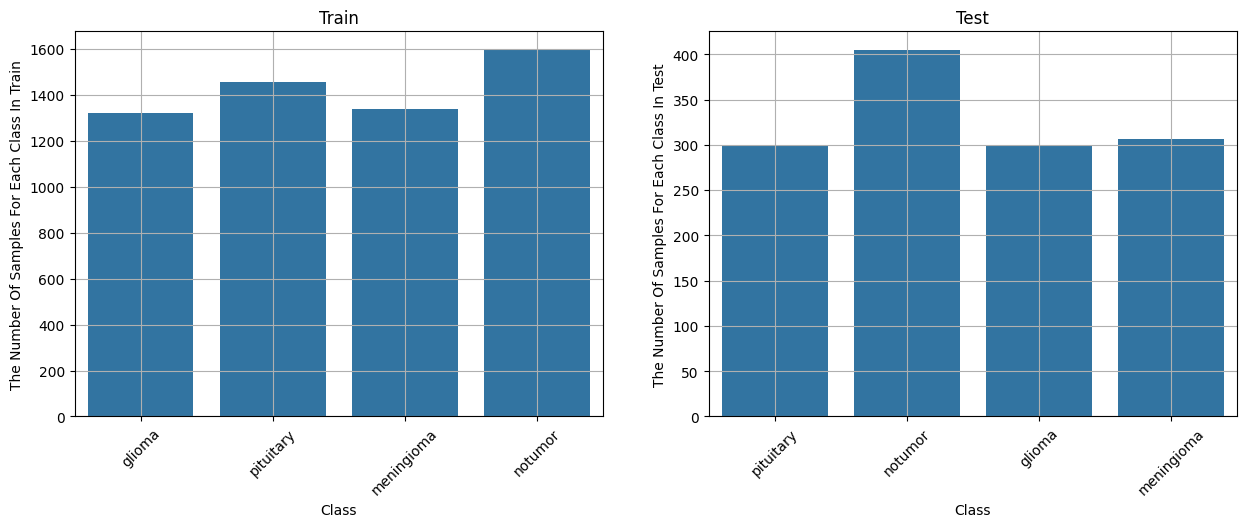

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

**Preprocessing The Image**

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 224


for label in labels:
    trainPath = os.path.join(train_set,label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0)# load images in gray.
        image = Image.fromarray(image)# Convert the image to a PIL image.
        contrast = ImageEnhance.Contrast(image)  # improving contrast
        image = contrast.enhance(1.2)
        brightness = ImageEnhance.Brightness(image)  # improving brightness
        image = brightness.enhance(1.1)
        sharpness = ImageEnhance.Sharpness(image)  # improving Sharpness
        image = sharpness.enhance(1.2)
        image = np.array(image)
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 224*224.

        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join(test_set,label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = Image.fromarray(image)# Convert the image to a PIL image.
        contrast = ImageEnhance.Contrast(image)  # improving contrast
        image = contrast.enhance(1.2)
        brightness = ImageEnhance.Brightness(image)  # improving brightness
        image = brightness.enhance(1.1)
        sharpness = ImageEnhance.Sharpness(image)  # improving Sharpness
        image = sharpness.enhance(1.2)
        image = np.array(image)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

100%|██████████| 300/300 [00:10<00:00, 28.20it/s]


In [ ]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = train_set
	testing = test_set
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 224

	for dir in training_dir:
		save_path = 'cleaned/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = 'cleaned/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

**Checking For Path Here We have 4 Labels**

In [ ]:
folders_train=glob('/content//cleaned/Training/*')
folders_train

['/content//cleaned/Training/notumor',
 '/content//cleaned/Training/glioma',
 '/content//cleaned/Training/pituitary',
 '/content//cleaned/Training/meningioma']

In [ ]:
folders_test=glob('/content//cleaned/Testing/*')
folders_test

['/content//cleaned/Testing/notumor',
 '/content//cleaned/Testing/glioma',
 '/content//cleaned/Testing/pituitary',
 '/content//cleaned/Testing/meningioma']

In [ ]:
len(folders_train)

4

**Training the Dataset**

In [ ]:
x= tf.keras.layers.GlobalAveragePooling2D()(inception.output)
x= Dense(128,activation='relu')(x)
x= Dropout(0.2)(x)

In [ ]:
prediction=Dense(4, activation='softmax')(x)

inception.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model=Model(inception.input, prediction)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.AUC()])

**For Normalizing**

In [ ]:
# train_datagen=ImageDataGenerator(rescale=1./255,
#                                  shear_range=0.2,
#                                  zoom_range=0.2,
#                                  horizontal_flip=False)

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# test_datagen=ImageDataGenerator(rescale=1./255)


In [ ]:
# train_set=train_datagen.flow_from_directory('/content//cleaned/Training',
#                                             target_size=(224,224),
#                                             batch_size=64,
#                                             class_mode='categorical'
#                                             )
train_set = datagen.flow_from_directory(
    '/content//cleaned/Training',
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    subset='training'
)

Found 4571 images belonging to 4 classes.


**Creating Batches**

In [ ]:
# test_set=test_datagen.flow_from_directory('/content//cleaned/Testing',
#                                             target_size=(224,224),
#                                             batch_size=64,
#                                             class_mode='categorical'
#                                             )

test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content//cleaned/Testing',
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


**Callback Function**

In [ ]:
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
callback =tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [ ]:
r=model.fit(train_set,validation_data=test_set,
                      epochs=150,
                      callbacks=[early_stop,callback,model_checkpoint_callback])

Epoch 1/150
191/191 [==============================] - 82s 366ms/step - loss: 0.6636 - accuracy: 0.7373 - specificity_at_sensitivity: 0.9796 - auc: 0.9248 - val_loss: 0.5387 - val_accuracy: 0.7857 - val_specificity_at_sensitivity: 0.9888 - val_auc: 0.9498
Epoch 2/150
191/191 [==============================] - 67s 349ms/step - loss: 0.4891 - accuracy: 0.8143 - specificity_at_sensitivity: 0.9905 - auc: 0.9580 - val_loss: 0.5473 - val_accuracy: 0.7857 - val_specificity_at_sensitivity: 0.9896 - val_auc: 0.9499
Epoch 3/150
191/191 [==============================] - 65s 340ms/step - loss: 0.4419 - accuracy: 0.8315 - specificity_at_sensitivity: 0.9938 - auc: 0.9655 - val_loss: 0.5417 - val_accuracy: 0.7796 - val_specificity_at_sensitivity: 0.9929 - val_auc: 0.9519
Epoch 4/150
191/191 [==============================] - 65s 342ms/step - loss: 0.4024 - accuracy: 0.8464 - specificity_at_sensitivity: 0.9956 - auc: 0.9711 - val_loss: 0.4853 - val_accuracy: 0.8185 - val_specificity_at_sensitivity: 0

**Checking The Results**

In [ ]:
df_inception = pd.DataFrame(r.history)
df_inception.tail()

,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
22,0.301989,0.883177,0.998396,0.983169,0.392782,0.848970,0.996949,0.973864
23,0.284745,0.894334,0.998469,0.984798,0.390246,0.855835,0.997457,0.974032
24,0.290001,0.889302,0.998031,0.984087,0.393173,0.857361,0.997457,0.974110
25,0.283254,0.886677,0.998833,0.984877,0.401667,0.855835,0.997203,0.974227
26,0.275370,0.895865,0.998760,0.985800,0.406998,0.848970,0.997203,0.972644


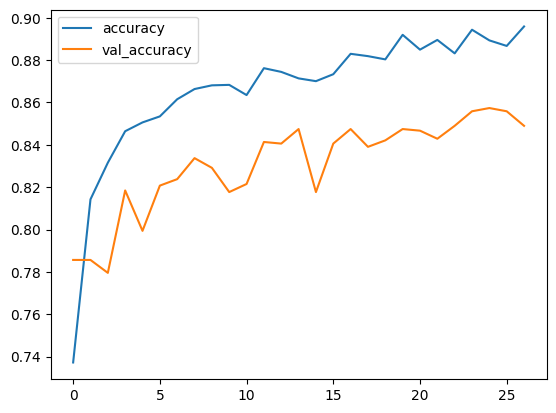

In [ ]:
df_inception[["accuracy","val_accuracy"]].plot();

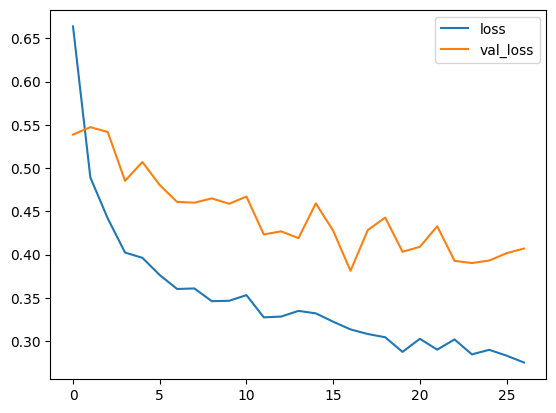

In [ ]:
df_inception[["loss","val_loss"]].plot();

In [ ]:
hist_=pd.DataFrame(r.history)
hist_


,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
0,0.663585,0.737257,0.979581,0.924842,0.538684,0.785660,0.988813,0.949776
1,0.489111,0.814264,0.990520,0.958047,0.547254,0.785660,0.989575,0.949853
2,0.441929,0.831547,0.993801,0.965546,0.541711,0.779558,0.992881,0.951929
3,0.402372,0.846423,0.995625,0.971067,0.485275,0.818459,0.993389,0.959811
4,0.396276,0.850580,0.995697,0.971899,0.507003,0.799390,0.994152,0.956997
5,0.376392,0.853424,0.996791,0.974783,0.480370,0.820747,0.993135,0.960119
6,0.360320,0.861518,0.996354,0.976484,0.460890,0.823799,0.994406,0.964595
7,0.360897,0.866331,0.996791,0.976516,0.460020,0.833715,0.994406,0.963982
8,0.346209,0.868081,0.997448,0.978573,0.464962,0.829138,0.993898,0.962999
9,0.346627,0.868300,0.997739,0.978241,0.458751,0.817696,0.995678,0.964800


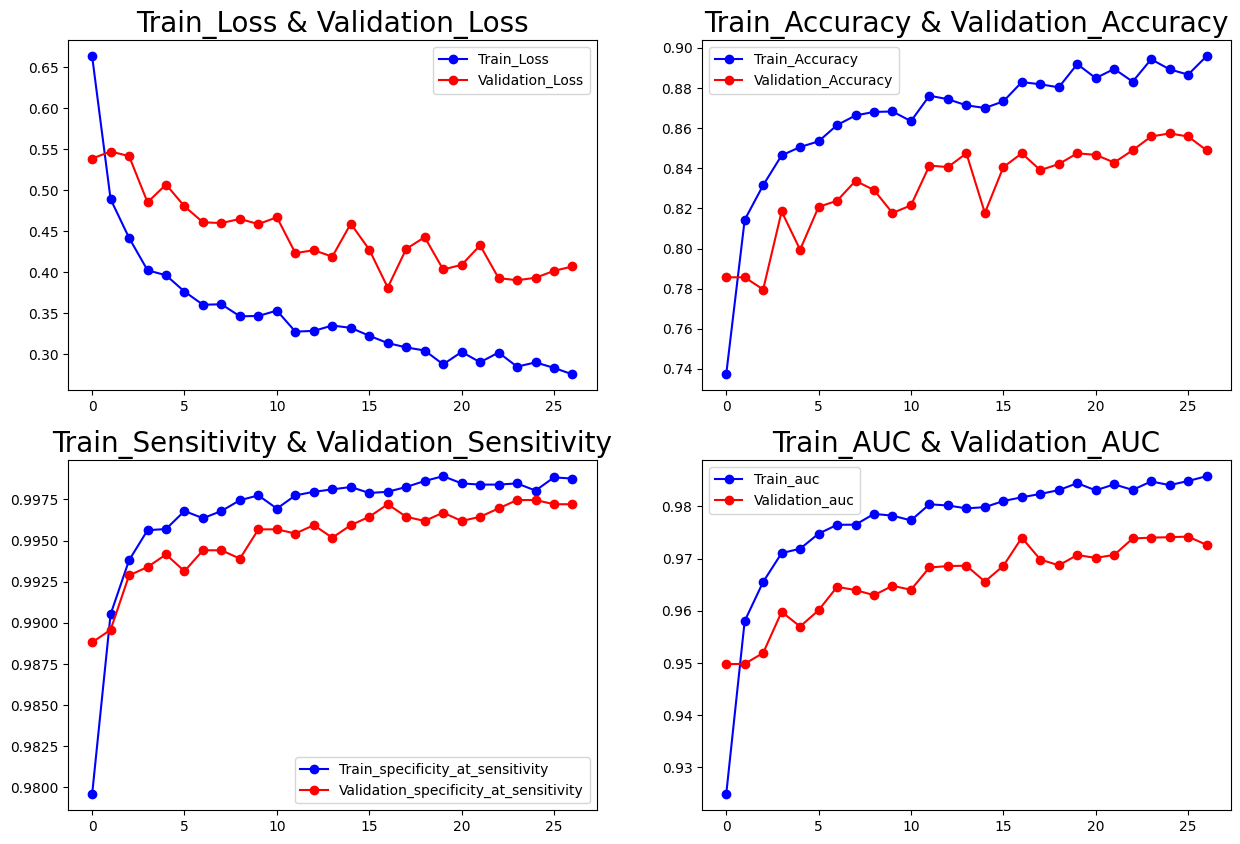

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score, acc ,sensitivity,auc= model.evaluate(test_set)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

55/55 [==============================] - 3s 58ms/step - loss: 0.4070 - accuracy: 0.8490 - specificity_at_sensitivity: 0.9972 - auc: 0.9726
Test Loss = 0.4069980978965759
Test Accuracy = 0.8489702343940735
Test Sensitivity = 0.9972031712532043
Test AUC = 0.9726436734199524


In [ ]:
y_test =test_set.classes
predictions = model.predict(test_set)

# Find the class with the highest predicted probability for each sample
y_pred = np.argmax(predictions, axis=1)

y_test = np.ravel(y_test)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
print(df)

55/55 [==============================] - 5s 65ms/step
      Actual  Prediction
0          0           0
1          0           0
2          0           0
3          0           0
4          0           2
...      ...         ...
1306       3           3
1307       3           3
1308       3           3
1309       3           3
1310       3           3

[1311 rows x 2 columns]


array([[230,  55,   4,  11],
       [ 23, 208,  43,  32],
       [  3,   8, 391,   3],
       [  3,  10,   3, 284]])

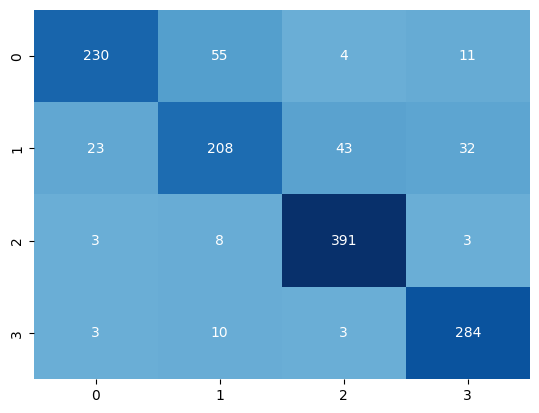

In [ ]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.89      0.77      0.82       300
           1       0.74      0.68      0.71       306
           2       0.89      0.97      0.92       405
           3       0.86      0.95      0.90       300

    accuracy                           0.85      1311
   macro avg       0.84      0.84      0.84      1311
weighted avg       0.85      0.85      0.85      1311



## **Just taking tumor categories**

In [ ]:
import shutil
import os

In [ ]:
drop=('/content//cleaned/Training/notumor')
shutil.rmtree(drop)

In [ ]:
folders_train=glob('/content//cleaned/Training/*')
folders_train

['/content//cleaned/Training/pituitary',
 '/content//cleaned/Training/glioma',
 '/content//cleaned/Training/meningioma']

In [ ]:
shutil.rmtree('/content//cleaned/Testing/notumor')

In [ ]:
folders_test=glob('/content//cleaned/Testing/*')
folders_test

['/content//cleaned/Testing/pituitary',
 '/content//cleaned/Testing/glioma',
 '/content//cleaned/Testing/meningioma']

In [ ]:
len(folders_train)

3

In [ ]:
len(folders_test)

3

In [ ]:
x= tf.keras.layers.GlobalAveragePooling2D()(inception.output)
x= Dense(128,activation='relu')(x)
x= Dropout(0.2)(x)

In [ ]:
prediction=Dense(3, activation='softmax')(x)

inception.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model1=Model(inception.input, prediction)
model1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.AUC()])

In [ ]:
datagen1 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
train_set1 = datagen1.flow_from_directory(
    '/content//cleaned/Training',
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    subset='training'
)

Found 3295 images belonging to 3 classes.


In [ ]:
test_set1 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content//cleaned/Testing',
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    shuffle=False
)

Found 906 images belonging to 3 classes.


In [ ]:
r=model1.fit(train_set1,validation_data=test_set1,
                      epochs=150,
                      callbacks=[early_stop,callback,model_checkpoint_callback])

Epoch 1/150
138/138 [==============================] - 70s 382ms/step - loss: 0.8457 - accuracy: 0.6288 - specificity_at_sensitivity: 0.8854 - auc: 0.8043 - val_loss: 0.6904 - val_accuracy: 0.7009 - val_specificity_at_sensitivity: 0.9514 - val_auc: 0.8712
Epoch 2/150
138/138 [==============================] - 48s 347ms/step - loss: 0.5731 - accuracy: 0.7642 - specificity_at_sensitivity: 0.9704 - auc: 0.9114 - val_loss: 0.5994 - val_accuracy: 0.7296 - val_specificity_at_sensitivity: 0.9685 - val_auc: 0.9025
Epoch 3/150
138/138 [==============================] - 54s 393ms/step - loss: 0.5232 - accuracy: 0.7918 - specificity_at_sensitivity: 0.9754 - auc: 0.9258 - val_loss: 0.5527 - val_accuracy: 0.7792 - val_specificity_at_sensitivity: 0.9658 - val_auc: 0.9154
Epoch 4/150
138/138 [==============================] - 47s 337ms/step - loss: 0.4799 - accuracy: 0.8076 - specificity_at_sensitivity: 0.9810 - auc: 0.9372 - val_loss: 0.5987 - val_accuracy: 0.7395 - val_specificity_at_sensitivity: 0

In [ ]:
df_inception = pd.DataFrame(r.history)
df_inception.tail()

,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
59,0.326893,0.871017,0.995448,0.970059,0.462811,0.826711,0.993378,0.954883
60,0.316509,0.866464,0.996965,0.971961,0.447273,0.824503,0.992826,0.952944
61,0.296596,0.881335,0.997117,0.975584,0.427011,0.832230,0.993378,0.956753
62,0.306643,0.877997,0.996965,0.973789,0.377797,0.849890,0.995585,0.962208
63,0.318776,0.874962,0.996055,0.971645,0.403718,0.843267,0.992826,0.960164


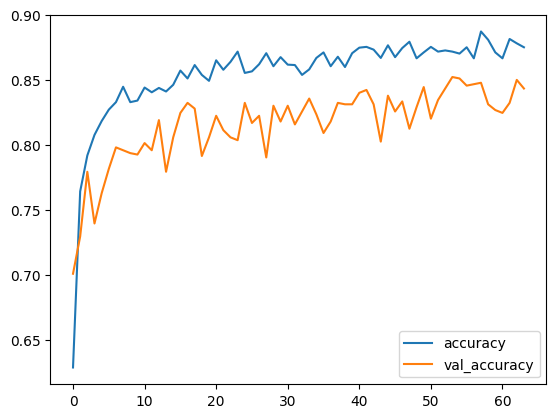

In [ ]:
df_inception[["accuracy","val_accuracy"]].plot();

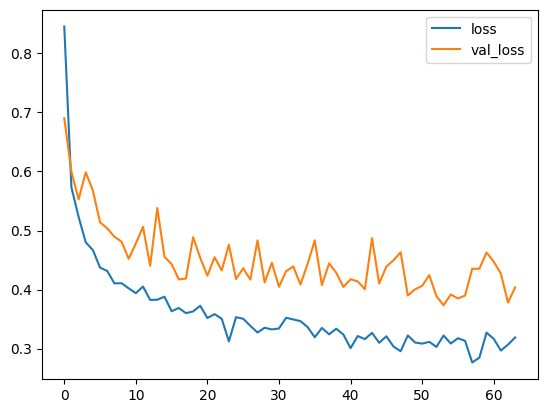

In [ ]:
df_inception[["loss","val_loss"]].plot();

In [ ]:
hist_=pd.DataFrame(r.history)
hist_

,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
0,0.845696,0.628832,0.885432,0.804334,0.690436,0.700883,0.951435,0.871178
1,0.573083,0.764188,0.970410,0.911426,0.599417,0.729581,0.968543,0.902540
2,0.523230,0.791806,0.975417,0.925797,0.552694,0.779249,0.965784,0.915361
3,0.479923,0.807587,0.981032,0.937197,0.598684,0.739514,0.978477,0.911343
4,0.466820,0.818209,0.984674,0.940746,0.567465,0.762693,0.965784,0.913092
...,...,...,...,...,...,...,...,...
59,0.326893,0.871017,0.995448,0.970059,0.462811,0.826711,0.993378,0.954883
60,0.316509,0.866464,0.996965,0.971961,0.447273,0.824503,0.992826,0.952944
61,0.296596,0.881335,0.997117,0.975584,0.427011,0.832230,0.993378,0.956753
62,0.306643,0.877997,0.996965,0.973789,0.377797,0.849890,0.995585,0.962208


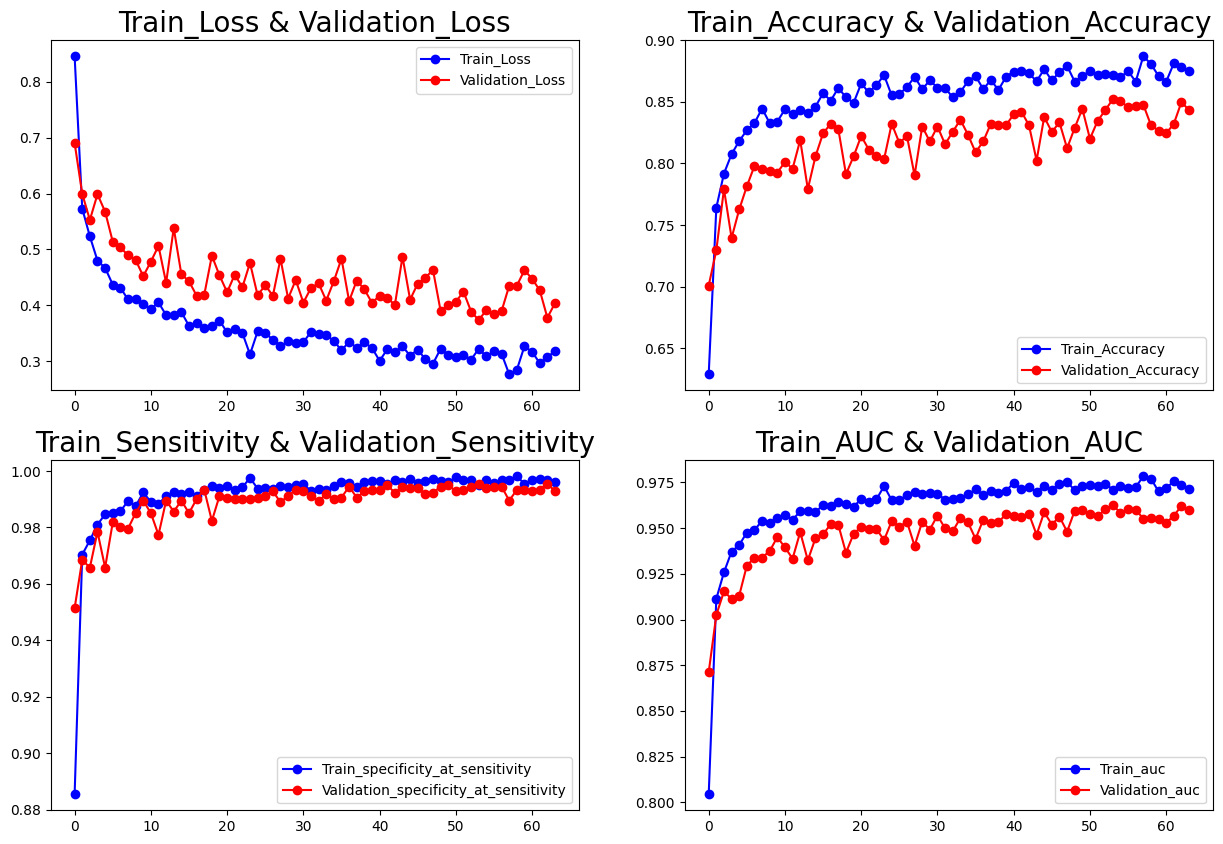

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score,acc,sensitivity,auc= model1.evaluate(test_set1)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

38/38 [==============================] - 4s 108ms/step - loss: 0.4037 - accuracy: 0.8433 - specificity_at_sensitivity: 0.9928 - auc: 0.9602
Test Loss = 0.40371841192245483
Test Accuracy = 0.8432670831680298
Test Sensitivity = 0.9928256273269653
Test AUC = 0.9601643681526184


In [ ]:
y_test1 =test_set1.classes
predictions = model1.predict(test_set1)

# Find the class with the highest predicted probability for each sample
y_pred1 = np.argmax(predictions, axis=1)

y_test1 = np.ravel(y_test1)
df = pd.DataFrame({'Actual': y_test1, 'Prediction': y_pred1})
print(df)

38/38 [==============================] - 7s 92ms/step
     Actual  Prediction
0         0           0
1         0           0
2         0           0
3         0           0
4         0           0
..      ...         ...
901       2           2
902       2           2
903       2           2
904       2           2
905       2           2

[906 rows x 2 columns]


array([[222,  68,  10],
       [ 18, 250,  38],
       [  0,   8, 292]])

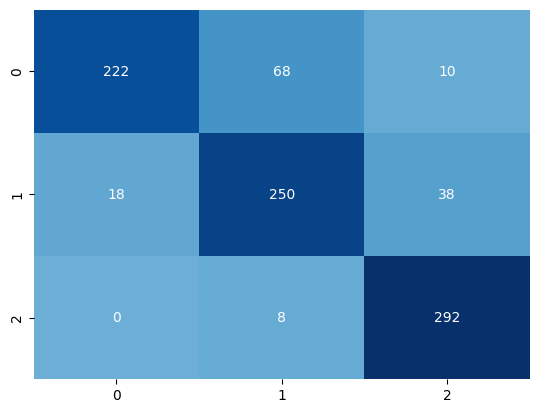

In [ ]:
CM = confusion_matrix(y_test1,y_pred1)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test1,y_pred1)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.93      0.74      0.82       300
           1       0.77      0.82      0.79       306
           2       0.86      0.97      0.91       300

    accuracy                           0.84       906
   macro avg       0.85      0.84      0.84       906
weighted avg       0.85      0.84      0.84       906



## **Now With just Tumor and No tumor Category**

In [ ]:
test_set2 = '/content/drive/MyDrive/Dataset/Testing'
train_set2='/content/drive/MyDrive/Dataset/Training'

In [ ]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [ ]:
test2=data('/content/drive/MyDrive/Dataset/Testing')

In [ ]:
train2=data('/content/drive/MyDrive/Dataset/Training')

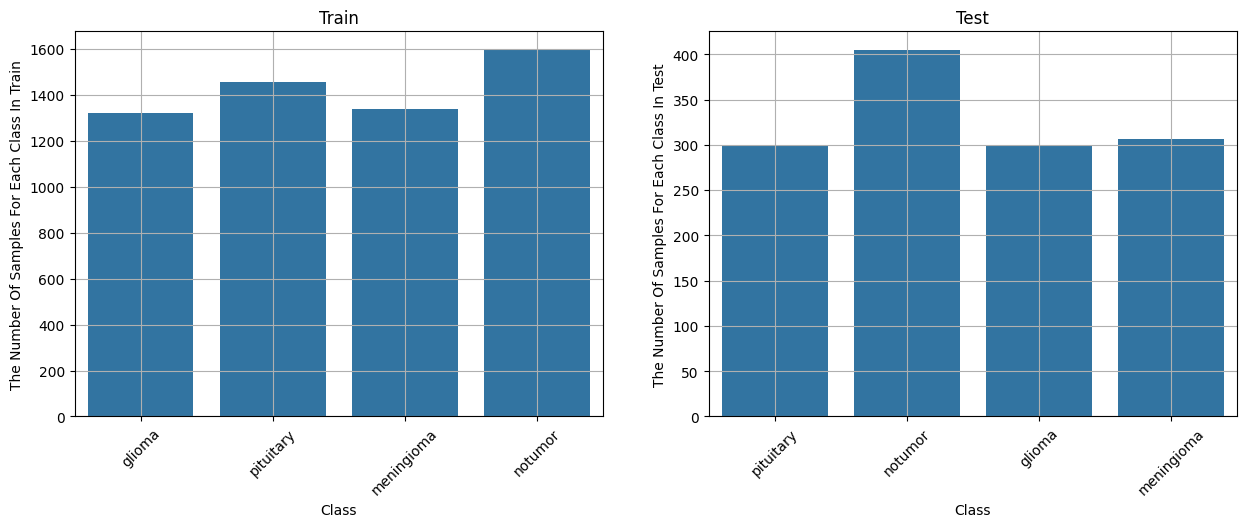

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ax = sns.countplot(x=train2.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,2,2)
ax = sns.countplot(x=test2.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 224


for label in labels:
    trainPath = os.path.join(train_set2,label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0)# load images in gray.
        image = Image.fromarray(image)# Convert the image to a PIL image.
        contrast = ImageEnhance.Contrast(image)  # improving contrast
        image = contrast.enhance(1.2)
        brightness = ImageEnhance.Brightness(image)  # improving brightness
        image = brightness.enhance(1.1)
        sharpness = ImageEnhance.Sharpness(image)  # improving Sharpness
        image = sharpness.enhance(1.2)
        image = np.array(image)
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image.
        image = cv2.resize(image, (image_size, image_size)) # resize images into 224*224.

        x_train.append(image)
        y_train.append(labels.index(label))

    testPath = os.path.join(test_set2,label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = Image.fromarray(image)# Convert the image to a PIL image.
        contrast = ImageEnhance.Contrast(image)  # improving contrast
        image = contrast.enhance(1.2)
        brightness = ImageEnhance.Brightness(image)  # improving brightness
        image = brightness.enhance(1.1)
        sharpness = ImageEnhance.Sharpness(image)  # improving Sharpness
        image = sharpness.enhance(1.2)
        image = np.array(image)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))

100%|██████████| 300/300 [00:07<00:00, 41.82it/s]


In [ ]:
def crop_img(img):
	"""
	Finds the extreme points on the image and crops the rectangular out of them
	"""
	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

if __name__ == "__main__":
	training = train_set
	testing = test_set
	training_dir = os.listdir(training)
	testing_dir = os.listdir(testing)
	IMG_SIZE = 224

	for dir in training_dir:
		save_path = 'cleanedagain/Training/'+ dir
		path = os.path.join(training,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

	for dir in testing_dir:
		save_path = 'cleanedagain/Testing/'+ dir
		path = os.path.join(testing,dir)
		image_dir = os.listdir(path)
		for img in image_dir:
			image = cv2.imread(os.path.join(path,img))
			new_img = crop_img(image)
			new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
			if not os.path.exists(save_path):
				os.makedirs(save_path)
			cv2.imwrite(save_path+'/'+img, new_img)

In [ ]:
folders_train=glob('/content//cleanedagain/Training/*')
folders_train

['/content//cleanedagain/Training/glioma',
 '/content//cleanedagain/Training/pituitary',
 '/content//cleanedagain/Training/meningioma',
 '/content//cleanedagain/Training/notumor']

In [ ]:
folders_test=glob('/content//cleanedagain/Testing/*')
folders_test

['/content//cleanedagain/Testing/glioma',
 '/content//cleanedagain/Testing/pituitary',
 '/content//cleanedagain/Testing/meningioma',
 '/content//cleanedagain/Testing/notumor']

In [ ]:
import os
import shutil

# Path to your training directory
train_dir =('/content/cleanedagain/Training')

# Names of the categories you want to merge
categories_to_merge = ['glioma', 'meningioma', 'pituitary']  # Replace with your actual category names

# Name of the new merged category
merged_category_name = 'tumor'

# Create the new merged category folder
merged_category_path = os.path.join(train_dir, merged_category_name)
os.makedirs(merged_category_path, exist_ok=True)  # Create if it doesn't exist

# Move images from the three categories to the merged folder
for category in categories_to_merge:
    category_path = os.path.join(train_dir, category)
    for image_file in os.listdir(category_path):
        source_path = os.path.join(category_path, image_file)
        destination_path = os.path.join(merged_category_path, image_file)
        shutil.move(source_path, destination_path)  # Move the image


In [ ]:
import os
import shutil

# Path to your training directory
test_dir =('/content/cleanedagain/Testing')

# Names of the categories you want to merge
categories_to_merge = ['glioma', 'meningioma', 'pituitary']  # Replace with your actual category names

# Name of the new merged category
merged_category_name = 'tumor'

# Create the new merged category folder
merged_category_path = os.path.join(test_dir, merged_category_name)
os.makedirs(merged_category_path, exist_ok=True)  # Create if it doesn't exist

# Move images from the three categories to the merged folder
for category in categories_to_merge:
    category_path = os.path.join(test_dir, category)
    for image_file in os.listdir(category_path):
        source_path = os.path.join(category_path, image_file)
        destination_path = os.path.join(merged_category_path, image_file)
        shutil.move(source_path, destination_path)  # Move the image

In [ ]:
drop=('/content//cleanedagain/Training/pituitary')
shutil.rmtree(drop)

In [ ]:
drop=('/content//cleanedagain/Training/glioma')
shutil.rmtree(drop)

In [ ]:
drop=('/content//cleanedagain/Training/meningioma')
shutil.rmtree(drop)

In [ ]:
folders_train=glob('/content//cleaned/Training/*')
folders_train

[]

In [ ]:
drop=('/content//cleanedagain/Testing/pituitary')
shutil.rmtree(drop)

In [ ]:
drop=('/content//cleanedagain/Testing/glioma')
shutil.rmtree(drop)

In [ ]:
drop=('/content//cleanedagain/Testing/meningioma')
shutil.rmtree(drop)

In [ ]:
folders_test=glob('/content//cleanedagain/Testing/*')
folders_test

['/content//cleanedagain/Testing/tumor',
 '/content//cleanedagain/Testing/notumor']

In [ ]:
x= tf.keras.layers.GlobalAveragePooling2D()(inception.output)
x= Dense(128,activation='relu')(x)
x= Dropout(0.2)(x)

In [ ]:
prediction=Dense(2, activation='softmax')(x)

inception.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [ ]:
model2=Model(inception.input, prediction)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [ ]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', keras.metrics.SpecificityAtSensitivity(0.5), keras.metrics.AUC()])

In [ ]:
datagen1 = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
train_set2 = datagen1.flow_from_directory(
    '/content//cleanedagain/Training',
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    subset='training'
)

Found 4570 images belonging to 2 classes.


In [ ]:
test_set2 = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/content//cleanedagain/Testing',
    target_size=(224, 224),
    batch_size=24,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 2 classes.


In [ ]:
r=model2.fit(train_set2,validation_data=test_set2,
                      epochs=150,
                      callbacks=[early_stop,callback,model_checkpoint_callback])

Epoch 1/150
191/191 [==============================] - 85s 379ms/step - loss: 0.1999 - accuracy: 0.9282 - specificity_at_sensitivity: 0.9921 - auc: 0.9742 - val_loss: 0.1485 - val_accuracy: 0.9504 - val_specificity_at_sensitivity: 0.9977 - val_auc: 0.9853
Epoch 2/150
191/191 [==============================] - 65s 339ms/step - loss: 0.1064 - accuracy: 0.9619 - specificity_at_sensitivity: 0.9989 - auc: 0.9921 - val_loss: 0.1489 - val_accuracy: 0.9527 - val_specificity_at_sensitivity: 0.9969 - val_auc: 0.9864
Epoch 3/150
191/191 [==============================] - 64s 336ms/step - loss: 0.1017 - accuracy: 0.9641 - specificity_at_sensitivity: 0.9989 - auc: 0.9928 - val_loss: 0.1349 - val_accuracy: 0.9565 - val_specificity_at_sensitivity: 0.9977 - val_auc: 0.9879
Epoch 4/150
191/191 [==============================] - 65s 340ms/step - loss: 0.0887 - accuracy: 0.9696 - specificity_at_sensitivity: 0.9989 - auc: 0.9943 - val_loss: 0.1353 - val_accuracy: 0.9573 - val_specificity_at_sensitivity: 0

In [ ]:
df_inception = pd.DataFrame(r.history)
df_inception.tail()

,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
37,0.049651,0.980963,0.999562,0.998153,0.095147,0.970252,0.995423,0.992568
38,0.045255,0.983807,0.999344,0.998211,0.100994,0.979405,0.993898,0.991997
39,0.038491,0.985777,0.999562,0.998728,0.098856,0.977117,0.994661,0.992527
40,0.041449,0.985558,0.999562,0.998597,0.090632,0.975591,0.997712,0.995187
41,0.034564,0.987965,0.999562,0.998855,0.094128,0.977879,0.997712,0.995350


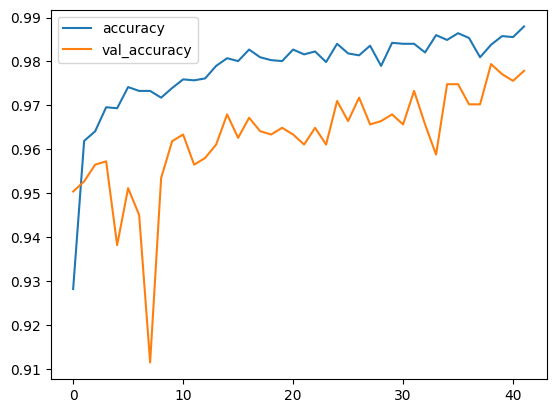

In [ ]:
df_inception[["accuracy","val_accuracy"]].plot();

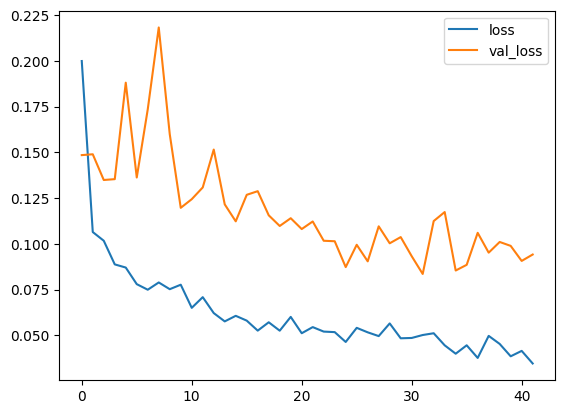

In [ ]:
df_inception[["loss","val_loss"]].plot();

In [ ]:
hist_=pd.DataFrame(r.history)
hist_

,loss,accuracy,specificity_at_sensitivity,auc,val_loss,val_accuracy,val_specificity_at_sensitivity,val_auc
0,0.199912,0.928228,0.992123,0.974198,0.148477,0.950420,0.997712,0.985321
1,0.106426,0.961926,0.998906,0.992051,0.148934,0.952708,0.996949,0.986385
2,0.101655,0.964114,0.998906,0.992818,0.134874,0.956522,0.997712,0.987885
3,0.088735,0.969584,0.998906,0.994289,0.135331,0.957285,0.996949,0.988193
4,0.087005,0.969365,0.999344,0.994742,0.188078,0.938215,0.993898,0.980075
5,0.077930,0.974179,0.998906,0.995419,0.136242,0.951182,0.996949,0.987621
6,0.074886,0.973304,0.999344,0.996134,0.173521,0.945080,0.993898,0.983346
7,0.078859,0.973304,0.999562,0.995753,0.218254,0.911518,0.994661,0.972944
8,0.075178,0.971772,1.000000,0.996426,0.159914,0.953471,0.995423,0.986923
9,0.077623,0.973961,0.998249,0.994965,0.119662,0.961861,0.997712,0.991195


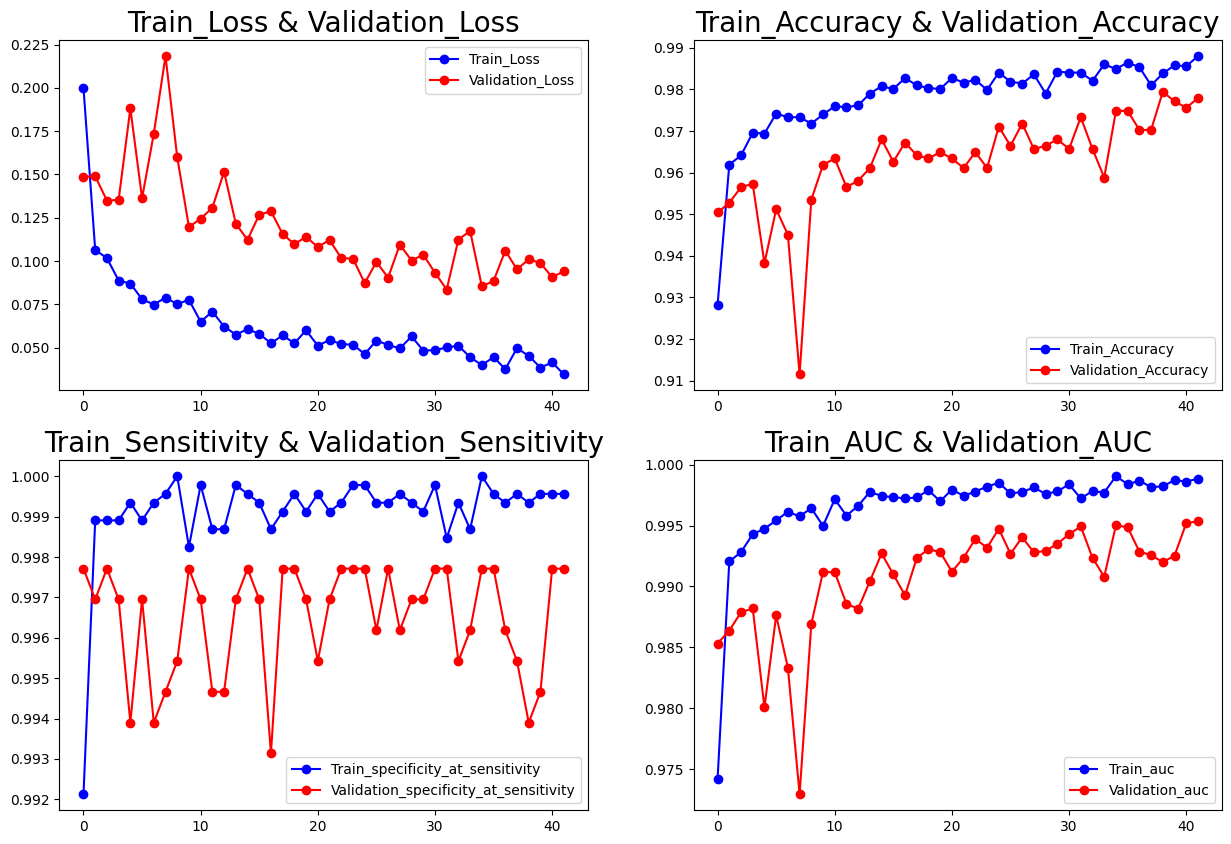

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [ ]:
score,acc,sensitivity,auc= model2.evaluate(test_set2)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

55/55 [==============================] - 4s 64ms/step - loss: 0.0941 - accuracy: 0.9779 - specificity_at_sensitivity: 0.9977 - auc: 0.9954
Test Loss = 0.09412837028503418
Test Accuracy = 0.9778794646263123
Test Sensitivity = 0.9977116584777832
Test AUC = 0.9953500032424927


In [ ]:
y_test2 =test_set2.classes
predictions = model2.predict(test_set2)

# Find the class with the highest predicted probability for each sample
y_pred2 = np.argmax(predictions, axis=1)

y_test2 = np.ravel(y_test2)
df = pd.DataFrame({'Actual': y_test2, 'Prediction': y_pred2})
print(df)

55/55 [==============================] - 5s 58ms/step
      Actual  Prediction
0          0           1
1          0           0
2          0           0
3          0           0
4          0           1
...      ...         ...
1306       1           1
1307       1           1
1308       1           1
1309       1           1
1310       1           1

[1311 rows x 2 columns]


In [ ]:
 y_test2[0]

0

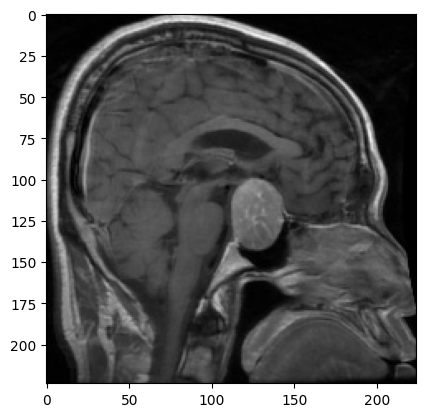

In [ ]:
import matplotlib.pyplot as plt

# Iterate through the dataset to access the 100th image
i = 0
for image, label in test_set2:
    if i == 0:
        plt.imshow(image[0])  # Assuming image is in a batch format
        plt.show()
        break
    i += 1

In [ ]:
y_pred2[0]

1

array([[392,  13],
       [ 16, 890]])

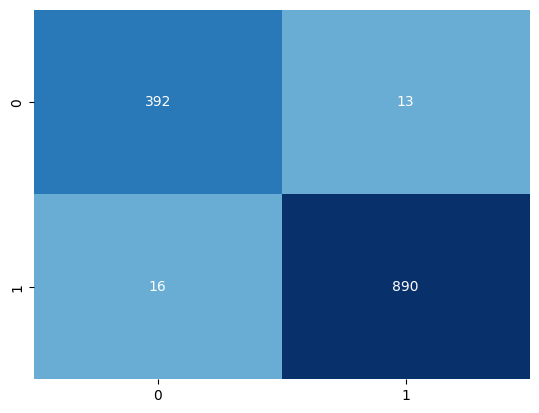

In [ ]:
CM = confusion_matrix(y_test2,y_pred2)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [ ]:
ClassificationReport = classification_report(y_test2,y_pred2)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.96      0.97      0.96       405
           1       0.99      0.98      0.98       906

    accuracy                           0.98      1311
   macro avg       0.97      0.98      0.97      1311
weighted avg       0.98      0.98      0.98      1311

